In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 5

# Size of data split for testing
train_size = 0.8

In [6]:
index = []

for i in range(days):
    index.append(np.arange(i,len(data),days))

In [7]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(len(index)):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [8]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

In [9]:
# Normalised chunks
historical_sequences_norm = np.array([data_norm[ix].copy() for ix in ordered_index])
next_day_open_values_norm = np.array([data_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
next_day_open_values_norm = np.expand_dims(next_day_open_values_norm, -1)

In [10]:
# Delete those sequences that doesn't have a -th day in the results
historical_sequences_norm = historical_sequences_norm[:next_day_open_values_norm.shape[0]]

In [11]:
historical_sequences_norm.shape

(4755, 92, 5)

In [12]:
next_day_open_values_norm.shape

(4755, 1)

In [60]:
# Y raw data
next_day_open_values = np.array([data.to_numpy()[ordered_index[i+days][-1],0] for i in range(len(ordered_index) - days)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.32507933],
       [0.31792447],
       [0.29925963],
       ...,
       [0.47601568],
       [0.44328999],
       [0.46319915]])

In [14]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

X_train = historical_sequences_norm[:split]
Y_train = next_day_open_values_norm[:split]

X_test = historical_sequences_norm[split:]
Y_test = next_day_open_values_norm[split:]
unscaled_y_test = next_day_open_values[split:]

# Model selection

##### Model constructor

In [15]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [16]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [17]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [18]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 1s 415us/step - loss: 0.0557 - val_loss: 0.0053
Epoch 2/24
3423/3423 [==============================] - 1s 158us/step - loss: 0.0042 - val_loss: 0.0028
Epoch 3/24
3423/3423 [==============================] - 1s 158us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/24
3423/3423 [==============================] - 1s 157us/step - loss: 0.0022 - val_loss: 0.0178
Epoch 5/24
3423/3423 [==============================] - 1s 163us/step - loss: 0.0037 - val_loss: 0.0565
Epoch 6/24
3423/3423 [==============================] - 1s 159us/step - loss: 0.0038 - val_loss: 0.0342
Epoch 7/24
3423/3423 [==============================] - 1s 157us/step - loss: 0.0118 - val_loss: 0.0439
Epoch 8/24
3423/3423 [==============================] - 1s 157us/step - loss: 0.0041 - val

3423/3423 [==============================] - 1s 335us/step - loss: 0.0061 - val_loss: 0.0149
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 3s 793us/step - loss: 3.4461 - val_loss: 0.0320
Epoch 2/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0350 - val_loss: 0.0028
Epoch 3/24
3423/3423 [==============================] - 2s 560us/step - loss: 0.0053 - val_loss: 0.0118
Epoch 4/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0050 - val_loss: 0.0027
Epoch 5/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0033 - val_loss: 0.0041
Epoch 6/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0027 - val_loss: 0.0032
Epoch 7/24
3423/3423 [==============================] - 2s 564us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/24
3423/3423 [==============================] - 2s 553us/step - loss: 0.0025 - val_loss: 0.0037
Epoch 9/24
3423/3423 [======

3423/3423 [==============================] - 2s 589us/step - loss: 0.0074 - val_loss: 0.0144
Epoch 5/24
3423/3423 [==============================] - 2s 588us/step - loss: 0.0049 - val_loss: 0.0042
Epoch 6/24
3423/3423 [==============================] - 2s 594us/step - loss: 0.0038 - val_loss: 0.0061
Epoch 7/24
3423/3423 [==============================] - 2s 598us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/24
3423/3423 [==============================] - 2s 589us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 9/24
3423/3423 [==============================] - 2s 594us/step - loss: 0.0027 - val_loss: 0.0042
Epoch 10/24
3423/3423 [==============================] - 2s 589us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 11/24
3423/3423 [==============================] - 2s 588us/step - loss: 0.0025 - val_loss: 0.0029
Epoch 12/24
3423/3423 [==============================] - 2s 590us/step - loss: 0.0024 - val_loss: 0.0032
Epoch 13/24
3423/3423 [==============================] - 2s 589us/step -

3423/3423 [==============================] - 2s 556us/step - loss: 0.0075 - val_loss: 0.0040
Epoch 10/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0073 - val_loss: 0.0035
Epoch 11/24
3423/3423 [==============================] - 2s 560us/step - loss: 0.0072 - val_loss: 0.0034
Epoch 12/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0064 - val_loss: 0.0034
Epoch 13/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0068 - val_loss: 0.0034
Epoch 14/24
3423/3423 [==============================] - 2s 566us/step - loss: 0.0063 - val_loss: 0.0034
Epoch 15/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0063 - val_loss: 0.0035
Epoch 16/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0062 - val_loss: 0.0036
Epoch 17/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0060 - val_loss: 0.0034
Epoch 18/24
3423/3423 [==============================] - 2s 555us/s

Epoch 14/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0549 - val_loss: 0.0092
Epoch 15/24
3423/3423 [==============================] - 2s 496us/step - loss: 0.0457 - val_loss: 0.0112
Epoch 16/24
3423/3423 [==============================] - 2s 484us/step - loss: 0.0215 - val_loss: 0.0289
Epoch 17/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0125 - val_loss: 0.0607
Epoch 18/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0108 - val_loss: 0.0145
Epoch 19/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0086 - val_loss: 0.0222
Epoch 20/24
3423/3423 [==============================] - 2s 491us/step - loss: 0.0073 - val_loss: 0.0183
Epoch 21/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0067 - val_loss: 0.0167
Epoch 22/24
3423/3423 [==============================] - 2s 486us/step - loss: 0.0063 - val_loss: 0.0223
Epoch 23/24
3423/3423 [==============================] 

Epoch 19/24
3423/3423 [==============================] - 2s 490us/step - loss: 0.0029 - val_loss: 0.0057
Epoch 20/24
3423/3423 [==============================] - 2s 491us/step - loss: 0.0026 - val_loss: 0.0036
Epoch 21/24
3423/3423 [==============================] - 2s 486us/step - loss: 0.0025 - val_loss: 0.0029
Epoch 22/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0024 - val_loss: 0.0033
Epoch 23/24
3423/3423 [==============================] - 2s 484us/step - loss: 0.0023 - val_loss: 0.0032
Epoch 24/24
3423/3423 [==============================] - 2s 486us/step - loss: 0.0023 - val_loss: 0.0030
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 3s 912us/step - loss: 0.1405 - val_loss: 0.0101
Epoch 2/24
3423/3423 [==============================] - 1s 352us/step - loss: 0.0752 - val_loss: 0.0315
Epoch 3/24
3423/3423 [==============================] - 1s 357us/step - loss: 0.0307 - val_loss: 0.0067
Epoch 4/24


3423/3423 [==============================] - 2s 554us/step - loss: 0.0181 - val_loss: 0.0054
Epoch 3/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0078 - val_loss: 0.0060
Epoch 4/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0056 - val_loss: 0.0123
Epoch 5/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 6/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0036 - val_loss: 0.0039
Epoch 7/24
3423/3423 [==============================] - 2s 561us/step - loss: 0.0032 - val_loss: 0.0053
Epoch 8/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 9/24
3423/3423 [==============================] - 2s 552us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 10/24
3423/3423 [==============================] - 2s 553us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 11/24
3423/3423 [==============================] - 2s 553us/step - l

3423/3423 [==============================] - 2s 556us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/24
3423/3423 [==============================] - 2s 561us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 11/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/24
3423/3423 [==============================] - 2s 561us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 13/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 14/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 15/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 16/24
3423/3423 [==============================] - 2s 554us/ste

3423/3423 [==============================] - 2s 556us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 13/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0045 - val_loss: 0.0095
Epoch 14/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0031 - val_loss: 0.0038
Epoch 15/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 16/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0098 - val_loss: 0.0054
Epoch 17/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 18/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0035 - val_loss: 0.0045
Epoch 19/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 20/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0038 - val_loss: 0.0030
Epoch 21/24
3423/3423 [==============================] - 2s 558us/s

Epoch 17/24
3423/3423 [==============================] - 1s 387us/step - loss: 0.0020 - val_loss: 0.0030
Epoch 18/24
3423/3423 [==============================] - 1s 387us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 19/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 20/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0018 - val_loss: 0.0029
Epoch 21/24
3423/3423 [==============================] - 1s 386us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 22/24
3423/3423 [==============================] - 1s 392us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 23/24
3423/3423 [==============================] - 1s 386us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 24/24
3423/3423 [==============================] - 1s 386us/step - loss: 0.0018 - val_loss: 0.0022
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 5s 1ms/step - loss: 0.1188 - val_loss: 0.0111
Epoch 2/24


Epoch 22/24
3423/3423 [==============================] - 2s 552us/step - loss: 0.0029 - val_loss: 0.0101
Epoch 23/24
3423/3423 [==============================] - 2s 551us/step - loss: 0.0025 - val_loss: 0.0049
Epoch 24/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0022 - val_loss: 0.0064
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 5s 1ms/step - loss: 0.4837 - val_loss: 0.0372
Epoch 2/24
3423/3423 [==============================] - 1s 399us/step - loss: 0.0676 - val_loss: 0.0133
Epoch 3/24
3423/3423 [==============================] - 1s 398us/step - loss: 0.0604 - val_loss: 0.0064
Epoch 4/24
3423/3423 [==============================] - 1s 399us/step - loss: 0.0649 - val_loss: 0.0138
Epoch 5/24
3423/3423 [==============================] - 1s 401us/step - loss: 0.0144 - val_loss: 0.0220
Epoch 6/24
3423/3423 [==============================] - 1s 398us/step - loss: 0.0062 - val_loss: 0.0434
Epoch 7/24
3423/

3423/3423 [==============================] - 1s 406us/step - loss: 0.0124 - val_loss: 0.0034
Epoch 3/24
3423/3423 [==============================] - 1s 398us/step - loss: 0.0038 - val_loss: 0.0045
Epoch 4/24
3423/3423 [==============================] - 1s 397us/step - loss: 0.0033 - val_loss: 0.0047
Epoch 5/24
3423/3423 [==============================] - 1s 397us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/24
3423/3423 [==============================] - 1s 399us/step - loss: 0.0032 - val_loss: 0.0038
Epoch 7/24
3423/3423 [==============================] - 1s 399us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/24
3423/3423 [==============================] - 1s 397us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/24
3423/3423 [==============================] - 1s 397us/step - loss: 0.0032 - val_loss: 0.0044
Epoch 10/24
3423/3423 [==============================] - 1s 398us/step - loss: 0.0031 - val_loss: 0.0046
Epoch 11/24
3423/3423 [==============================] - 1s 397us/step - l

3423/3423 [==============================] - 2s 559us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0027 - val_loss: 0.0030
Epoch 9/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/24
3423/3423 [==============================] - 2s 552us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 11/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 12/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 13/24
3423/3423 [==============================] - 2s 553us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 14/24
3423/3423 [==============================] - 2s 553us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 15/24
3423/3423 [==============================] - 2s 558us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 16/24
3423/3423 [==============================] - 2s 556us/ste

Epoch 15/24
3423/3423 [==============================] - 2s 529us/step - loss: 0.0023 - val_loss: 0.0151
Epoch 16/24
3423/3423 [==============================] - 2s 529us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 17/24
3423/3423 [==============================] - 2s 530us/step - loss: 0.0026 - val_loss: 0.0075
Epoch 18/24
3423/3423 [==============================] - 2s 531us/step - loss: 0.0021 - val_loss: 0.0050
Epoch 19/24
3423/3423 [==============================] - 2s 530us/step - loss: 0.0021 - val_loss: 0.0064
Epoch 20/24
3423/3423 [==============================] - 2s 529us/step - loss: 0.0023 - val_loss: 0.0031
Epoch 21/24
3423/3423 [==============================] - 2s 527us/step - loss: 0.0021 - val_loss: 0.0061
Epoch 22/24
3423/3423 [==============================] - 2s 527us/step - loss: 0.0020 - val_loss: 0.0078
Epoch 23/24
3423/3423 [==============================] - 2s 531us/step - loss: 0.0023 - val_loss: 0.0041
Epoch 24/24
3423/3423 [==============================] 

3423/3423 [==============================] - 2s 567us/step - loss: nan - val_loss: nan
Epoch 22/24
3423/3423 [==============================] - 2s 568us/step - loss: nan - val_loss: nan
Epoch 23/24
3423/3423 [==============================] - 2s 565us/step - loss: nan - val_loss: nan
Epoch 24/24
3423/3423 [==============================] - 2s 565us/step - loss: nan - val_loss: nan
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 6s 2ms/step - loss: 1.3427 - val_loss: 0.0057
Epoch 2/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0106 - val_loss: 0.0066
Epoch 3/24
3423/3423 [==============================] - 1s 365us/step - loss: 0.0110 - val_loss: 0.0099
Epoch 4/24
3423/3423 [==============================] - 1s 364us/step - loss: 0.0081 - val_loss: 0.0053
Epoch 5/24
3423/3423 [==============================] - 1s 365us/step - loss: 0.0060 - val_loss: 0.0061
Epoch 6/24
3423/3423 [=============================

3423/3423 [==============================] - 8s 2ms/step - loss: 0.0777 - val_loss: 0.0983
Epoch 2/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0484 - val_loss: 0.0052
Epoch 3/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0092 - val_loss: 0.0142
Epoch 4/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0072 - val_loss: 0.0140
Epoch 5/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0083 - val_loss: 0.0046
Epoch 6/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0043 - val_loss: 0.0061
Epoch 7/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0080 - val_loss: 0.0047
Epoch 8/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0047 - val_loss: 0.0056
Epoch 9/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0060 - val_loss: 0.0060
Epoch 10/24
3423/3423 [==============================] - 2s 557us/step - loss

3423/3423 [==============================] - 1s 388us/step - loss: 0.0044 - val_loss: 0.0054
Epoch 7/24
3423/3423 [==============================] - 1s 386us/step - loss: 0.0039 - val_loss: 0.0034
Epoch 8/24
3423/3423 [==============================] - 1s 383us/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/24
3423/3423 [==============================] - 1s 386us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/24
3423/3423 [==============================] - 1s 383us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 11/24
3423/3423 [==============================] - 1s 383us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 13/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 14/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 15/24
3423/3423 [==============================] - 1s 383us/step

3423/3423 [==============================] - 1s 327us/step - loss: 0.0038 - val_loss: 0.0049
Epoch 12/24
3423/3423 [==============================] - 1s 326us/step - loss: 0.0040 - val_loss: 0.0050
Epoch 13/24
3423/3423 [==============================] - 1s 334us/step - loss: 0.0037 - val_loss: 0.0052
Epoch 14/24
3423/3423 [==============================] - 1s 328us/step - loss: 0.0036 - val_loss: 0.0067
Epoch 15/24
3423/3423 [==============================] - 1s 327us/step - loss: 0.0035 - val_loss: 0.0055
Epoch 16/24
3423/3423 [==============================] - 1s 326us/step - loss: 0.0035 - val_loss: 0.0046
Epoch 17/24
3423/3423 [==============================] - 1s 324us/step - loss: 0.0035 - val_loss: 0.0047
Epoch 18/24
3423/3423 [==============================] - 1s 328us/step - loss: 0.0033 - val_loss: 0.0057
Epoch 19/24
3423/3423 [==============================] - 1s 327us/step - loss: 0.0032 - val_loss: 0.0058
Epoch 20/24
3423/3423 [==============================] - 1s 328us/s

Epoch 16/24
3423/3423 [==============================] - 2s 558us/step - loss: 0.0563 - val_loss: 0.0227
Epoch 17/24
3423/3423 [==============================] - 2s 558us/step - loss: 0.0555 - val_loss: 0.0220
Epoch 18/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0545 - val_loss: 0.0214
Epoch 19/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0537 - val_loss: 0.0209
Epoch 20/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0527 - val_loss: 0.0203
Epoch 21/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0517 - val_loss: 0.0196
Epoch 22/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0507 - val_loss: 0.0190
Epoch 23/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0497 - val_loss: 0.0185
Epoch 24/24
3423/3423 [==============================] - 2s 558us/step - loss: 0.0486 - val_loss: 0.0180
Train on 3423 samples, validate on 381 samples
Epoch 1/

Epoch 21/24
3423/3423 [==============================] - 2s 534us/step - loss: 0.0050 - val_loss: 0.0033
Epoch 22/24
3423/3423 [==============================] - 2s 536us/step - loss: 0.0052 - val_loss: 0.0033
Epoch 23/24
3423/3423 [==============================] - 2s 548us/step - loss: 0.0049 - val_loss: 0.0033
Epoch 24/24
3423/3423 [==============================] - 2s 539us/step - loss: 0.0050 - val_loss: 0.0033
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 9s 3ms/step - loss: 0.1104 - val_loss: 0.0198
Epoch 2/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0404 - val_loss: 0.0097
Epoch 3/24
3423/3423 [==============================] - 2s 548us/step - loss: 0.0319 - val_loss: 0.0074
Epoch 4/24
3423/3423 [==============================] - 2s 543us/step - loss: 0.0260 - val_loss: 0.0062
Epoch 5/24
3423/3423 [==============================] - 2s 541us/step - loss: 0.0209 - val_loss: 0.0053
Epoch 6/24
3423

3423/3423 [==============================] - 10s 3ms/step - loss: 0.1437 - val_loss: 0.0066
Epoch 2/24
3423/3423 [==============================] - 2s 570us/step - loss: 0.0149 - val_loss: 0.0208
Epoch 3/24
3423/3423 [==============================] - 2s 564us/step - loss: 0.0084 - val_loss: 0.0058
Epoch 4/24
3423/3423 [==============================] - 2s 563us/step - loss: 0.0048 - val_loss: 0.0038
Epoch 5/24
3423/3423 [==============================] - 2s 564us/step - loss: 0.0039 - val_loss: 0.0083
Epoch 6/24
3423/3423 [==============================] - 2s 563us/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/24
3423/3423 [==============================] - 2s 566us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 8/24
3423/3423 [==============================] - 2s 563us/step - loss: 0.0029 - val_loss: 0.0037
Epoch 9/24
3423/3423 [==============================] - 2s 567us/step - loss: 0.0027 - val_loss: 0.0035
Epoch 10/24
3423/3423 [==============================] - 2s 565us/step - los

3423/3423 [==============================] - 2s 547us/step - loss: 0.0033 - val_loss: 0.0025
Epoch 7/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/24
3423/3423 [==============================] - 2s 547us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 9/24
3423/3423 [==============================] - 2s 547us/step - loss: 0.0025 - val_loss: 0.0037
Epoch 10/24
3423/3423 [==============================] - 2s 550us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 11/24
3423/3423 [==============================] - 2s 547us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/24
3423/3423 [==============================] - 2s 548us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 13/24
3423/3423 [==============================] - 2s 551us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 14/24
3423/3423 [==============================] - 2s 550us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 15/24
3423/3423 [==============================] - 2s 548us/step

3423/3423 [==============================] - 2s 511us/step - loss: 1471547108208941820589113344.0000 - val_loss: 83588278031531114496.0000
Epoch 9/24
3423/3423 [==============================] - 2s 512us/step - loss: 55887388430194577380474880.0000 - val_loss: 83587697489391648768.0000
Epoch 10/24
3423/3423 [==============================] - 2s 508us/step - loss: 3864357354433746260346273792.0000 - val_loss: 83587037782414983168.0000
Epoch 11/24
3423/3423 [==============================] - 2s 506us/step - loss: 9057541831613643620612046848.0000 - val_loss: 83586835472275472384.0000
Epoch 12/24
3423/3423 [==============================] - 2s 507us/step - loss: 26816290609893505341849600.0000 - val_loss: 83586826676182450176.0000
Epoch 13/24
3423/3423 [==============================] - 2s 507us/step - loss: 7236175927800047270363136.0000 - val_loss: 83586817880089427968.0000
Epoch 14/24
3423/3423 [==============================] - 2s 506us/step - loss: 11510663017870225286627328.0000 - v

3423/3423 [==============================] - 2s 468us/step - loss: 0.0034 - val_loss: 0.0045
Epoch 9/24
3423/3423 [==============================] - 2s 466us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 10/24
3423/3423 [==============================] - 2s 473us/step - loss: 0.0029 - val_loss: 0.0040
Epoch 11/24
3423/3423 [==============================] - 2s 465us/step - loss: 0.0029 - val_loss: 0.0035
Epoch 12/24
3423/3423 [==============================] - 2s 466us/step - loss: 0.0028 - val_loss: 0.0032
Epoch 13/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0027 - val_loss: 0.0031
Epoch 14/24
3423/3423 [==============================] - 2s 467us/step - loss: 0.0026 - val_loss: 0.0030
Epoch 15/24
3423/3423 [==============================] - 2s 474us/step - loss: 0.0025 - val_loss: 0.0028
Epoch 16/24
3423/3423 [==============================] - 2s 467us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 17/24
3423/3423 [==============================] - 2s 470us/st

3423/3423 [==============================] - 1s 383us/step - loss: 0.0030 - val_loss: 0.0040
Epoch 14/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0029 - val_loss: 0.0046
Epoch 15/24
3423/3423 [==============================] - 1s 394us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 16/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0027 - val_loss: 0.0045
Epoch 17/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0025 - val_loss: 0.0044
Epoch 18/24
3423/3423 [==============================] - 1s 383us/step - loss: 0.0026 - val_loss: 0.0037
Epoch 19/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0024 - val_loss: 0.0044
Epoch 20/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0024 - val_loss: 0.0048
Epoch 21/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0024 - val_loss: 0.0043
Epoch 22/24
3423/3423 [==============================] - 1s 384us/s

3423/3423 [==============================] - 1s 383us/step - loss: 0.0044 - val_loss: 0.0505
Epoch 19/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0044 - val_loss: 0.0617
Epoch 20/24
3423/3423 [==============================] - 1s 382us/step - loss: 0.0042 - val_loss: 0.0090
Epoch 21/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0052 - val_loss: 0.0248
Epoch 22/24
3423/3423 [==============================] - 1s 384us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 23/24
3423/3423 [==============================] - 1s 383us/step - loss: 0.0053 - val_loss: 0.0152
Epoch 24/24
3423/3423 [==============================] - 1s 381us/step - loss: 0.0036 - val_loss: 0.0046
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 13s 4ms/step - loss: nan - val_loss: nan
Epoch 2/24
3423/3423 [==============================] - 1s 380us/step - loss: nan - val_loss: nan
Epoch 3/24
3423/3423 [=============

3423/3423 [==============================] - 15s 4ms/step - loss: 0.1001 - val_loss: 0.0466
Epoch 2/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0246 - val_loss: 0.0269
Epoch 3/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0104 - val_loss: 0.0062
Epoch 4/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0057 - val_loss: 0.0037
Epoch 5/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0038 - val_loss: 0.0048
Epoch 6/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0030 - val_loss: 0.0040
Epoch 8/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/24
3423/3423 [==============================] - 2s 575us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/24
3423/3423 [==============================] - 2s 569us/step - los

3423/3423 [==============================] - 2s 571us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 7/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0032 - val_loss: 0.0047
Epoch 8/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 9/24
3423/3423 [==============================] - 2s 570us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/24
3423/3423 [==============================] - 2s 570us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 11/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 12/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 13/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 14/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 15/24
3423/3423 [==============================] - 2s 570us/step

3423/3423 [==============================] - 2s 577us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 12/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0027 - val_loss: 0.0039
Epoch 13/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0028 - val_loss: 0.0038
Epoch 14/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 15/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0033 - val_loss: 0.0062
Epoch 16/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0037 - val_loss: 0.0047
Epoch 17/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0054 - val_loss: 0.0077
Epoch 18/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 19/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 20/24
3423/3423 [==============================] - 2s 569us/s

Epoch 16/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 17/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 18/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 19/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 20/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 21/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 22/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 23/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 24/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0016 - val_loss: 0.0019
Train on 3423 samples, validate on 381 samples
Epoch 1/

Epoch 21/24
3423/3423 [==============================] - 2s 472us/step - loss: 0.0088 - val_loss: 0.0092
Epoch 22/24
3423/3423 [==============================] - 2s 473us/step - loss: 0.0050 - val_loss: 0.0081
Epoch 23/24
3423/3423 [==============================] - 2s 473us/step - loss: 0.0071 - val_loss: 0.0060
Epoch 24/24
3423/3423 [==============================] - 2s 480us/step - loss: 0.0050 - val_loss: 0.0073
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 18s 5ms/step - loss: 0.3173 - val_loss: 0.0029
Epoch 2/24
3423/3423 [==============================] - 2s 543us/step - loss: 0.0074 - val_loss: 0.0029
Epoch 3/24
3423/3423 [==============================] - 2s 546us/step - loss: 0.0070 - val_loss: 0.0234
Epoch 4/24
3423/3423 [==============================] - 2s 543us/step - loss: 0.0102 - val_loss: 0.0065
Epoch 5/24
3423/3423 [==============================] - 2s 544us/step - loss: 0.0122 - val_loss: 0.0203
Epoch 6/24
342

3423/3423 [==============================] - 19s 6ms/step - loss: 0.1768 - val_loss: 0.0034
Epoch 2/24
3423/3423 [==============================] - 2s 547us/step - loss: 0.0064 - val_loss: 0.0127
Epoch 3/24
3423/3423 [==============================] - 2s 549us/step - loss: 0.0119 - val_loss: 0.0032
Epoch 4/24
3423/3423 [==============================] - 2s 548us/step - loss: 0.0052 - val_loss: 0.0083
Epoch 5/24
3423/3423 [==============================] - 2s 546us/step - loss: 0.0065 - val_loss: 0.0063
Epoch 6/24
3423/3423 [==============================] - 2s 547us/step - loss: 0.0062 - val_loss: 0.0088
Epoch 7/24
3423/3423 [==============================] - 2s 546us/step - loss: 0.0038 - val_loss: 0.0027
Epoch 8/24
3423/3423 [==============================] - 2s 547us/step - loss: 0.0034 - val_loss: 0.0049
Epoch 9/24
3423/3423 [==============================] - 2s 544us/step - loss: 0.0051 - val_loss: 0.0048
Epoch 10/24
3423/3423 [==============================] - 2s 546us/step - los

3423/3423 [==============================] - 1s 384us/step - loss: 0.0028 - val_loss: 0.0057
Epoch 8/24
3423/3423 [==============================] - 1s 383us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/24
3423/3423 [==============================] - 1s 381us/step - loss: 0.0025 - val_loss: 0.0034
Epoch 10/24
3423/3423 [==============================] - 1s 379us/step - loss: 0.0024 - val_loss: 0.0031
Epoch 11/24
3423/3423 [==============================] - 1s 381us/step - loss: 0.0023 - val_loss: 0.0031
Epoch 12/24
3423/3423 [==============================] - 1s 382us/step - loss: 0.0022 - val_loss: 0.0029
Epoch 13/24
3423/3423 [==============================] - 1s 382us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 14/24
3423/3423 [==============================] - 1s 381us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 15/24
3423/3423 [==============================] - 1s 385us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 16/24
3423/3423 [==============================] - 1s 380us/ste

3423/3423 [==============================] - 2s 496us/step - loss: 0.0091 - val_loss: 0.0046
Epoch 13/24
3423/3423 [==============================] - 2s 495us/step - loss: 0.0089 - val_loss: 0.0041
Epoch 14/24
3423/3423 [==============================] - 2s 495us/step - loss: 0.0090 - val_loss: 0.0042
Epoch 15/24
3423/3423 [==============================] - 2s 496us/step - loss: 0.0085 - val_loss: 0.0040
Epoch 16/24
3423/3423 [==============================] - 2s 496us/step - loss: 0.0080 - val_loss: 0.0039
Epoch 17/24
3423/3423 [==============================] - 2s 497us/step - loss: 0.0079 - val_loss: 0.0039
Epoch 18/24
3423/3423 [==============================] - 2s 499us/step - loss: 0.0076 - val_loss: 0.0040
Epoch 19/24
3423/3423 [==============================] - 2s 494us/step - loss: 0.0073 - val_loss: 0.0039
Epoch 20/24
3423/3423 [==============================] - 2s 494us/step - loss: 0.0074 - val_loss: 0.0043
Epoch 21/24
3423/3423 [==============================] - 2s 495us/s

3423/3423 [==============================] - 1s 418us/step - loss: 0.0031 - val_loss: 0.0074
Epoch 18/24
3423/3423 [==============================] - 1s 406us/step - loss: 0.0026 - val_loss: 0.0075
Epoch 19/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0024 - val_loss: 0.0043
Epoch 20/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0021 - val_loss: 0.0035
Epoch 21/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0021 - val_loss: 0.0048
Epoch 22/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0020 - val_loss: 0.0037
Epoch 23/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0019 - val_loss: 0.0034
Epoch 24/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0019 - val_loss: 0.0050

GENERATION 12

Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 23s 7ms/step - loss: nan - val_loss: nan
Epoch 2/24
3

3423/3423 [==============================] - 2s 578us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 24/24
3423/3423 [==============================] - 2s 575us/step - loss: 0.0020 - val_loss: 0.0022
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 24s 7ms/step - loss: 0.2489 - val_loss: 0.1973
Epoch 2/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0537 - val_loss: 0.0751
Epoch 3/24
3423/3423 [==============================] - 2s 579us/step - loss: 0.0209 - val_loss: 0.0352
Epoch 4/24
3423/3423 [==============================] - 2s 581us/step - loss: 0.0231 - val_loss: 0.0192
Epoch 5/24
3423/3423 [==============================] - 2s 581us/step - loss: 0.0177 - val_loss: 0.0291
Epoch 6/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0159 - val_loss: 0.0171
Epoch 7/24
3423/3423 [==============================] - 2s 579us/step - loss: 0.0107 - val_loss: 0.0197
Epoch 8/24
3423/3423 [======

3423/3423 [==============================] - 2s 570us/step - loss: 0.0092 - val_loss: 0.0045
Epoch 4/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0057 - val_loss: 0.0091
Epoch 5/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 6/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0037 - val_loss: 0.0059
Epoch 7/24
3423/3423 [==============================] - 2s 570us/step - loss: 0.0034 - val_loss: 0.0041
Epoch 8/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0032 - val_loss: 0.0048
Epoch 9/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0031 - val_loss: 0.0039
Epoch 10/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0030 - val_loss: 0.0040
Epoch 11/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0030 - val_loss: 0.0039
Epoch 12/24
3423/3423 [==============================] - 2s 574us/step - 

Epoch 8/24
3423/3423 [==============================] - 2s 584us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 9/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0029 - val_loss: 0.0038
Epoch 10/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0027 - val_loss: 0.0033
Epoch 11/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0026 - val_loss: 0.0032
Epoch 12/24
3423/3423 [==============================] - 2s 579us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 13/24
3423/3423 [==============================] - 2s 580us/step - loss: 0.0025 - val_loss: 0.0029
Epoch 14/24
3423/3423 [==============================] - 2s 580us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 15/24
3423/3423 [==============================] - 2s 586us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 16/24
3423/3423 [==============================] - 2s 585us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 17/24
3423/3423 [==============================] - 

Epoch 13/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0095 - val_loss: 0.0041
Epoch 14/24
3423/3423 [==============================] - 1s 391us/step - loss: 0.0090 - val_loss: 0.0044
Epoch 15/24
3423/3423 [==============================] - 1s 392us/step - loss: 0.0081 - val_loss: 0.0048
Epoch 16/24
3423/3423 [==============================] - 1s 391us/step - loss: 0.0075 - val_loss: 0.0052
Epoch 17/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0072 - val_loss: 0.0055
Epoch 18/24
3423/3423 [==============================] - 1s 389us/step - loss: 0.0070 - val_loss: 0.0060
Epoch 19/24
3423/3423 [==============================] - 1s 388us/step - loss: 0.0067 - val_loss: 0.0063
Epoch 20/24
3423/3423 [==============================] - 1s 391us/step - loss: 0.0065 - val_loss: 0.0068
Epoch 21/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0065 - val_loss: 0.0068
Epoch 22/24
3423/3423 [==============================] 

Epoch 18/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0729 - val_loss: 0.0312
Epoch 19/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0729 - val_loss: 0.0312
Epoch 20/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0729 - val_loss: 0.0314
Epoch 21/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0728 - val_loss: 0.0311
Epoch 22/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0728 - val_loss: 0.0307
Epoch 23/24
3423/3423 [==============================] - 2s 572us/step - loss: 0.0728 - val_loss: 0.0312
Epoch 24/24
3423/3423 [==============================] - 2s 570us/step - loss: 0.0728 - val_loss: 0.0310
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 28s 8ms/step - loss: 0.9029 - val_loss: 0.3196
Epoch 2/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.1319 - val_loss: 0.0350
Epoch 3/24


Epoch 23/24
3423/3423 [==============================] - 2s 512us/step - loss: 0.0088 - val_loss: 0.0036
Epoch 24/24
3423/3423 [==============================] - 2s 517us/step - loss: 0.0020 - val_loss: 0.0030
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 29s 9ms/step - loss: 0.1035 - val_loss: 0.0465
Epoch 2/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0324 - val_loss: 0.0212
Epoch 3/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0134 - val_loss: 0.0108
Epoch 4/24
3423/3423 [==============================] - 2s 584us/step - loss: 0.0078 - val_loss: 0.0100
Epoch 5/24
3423/3423 [==============================] - 2s 575us/step - loss: 0.0045 - val_loss: 0.0040
Epoch 6/24
3423/3423 [==============================] - 2s 579us/step - loss: 0.0034 - val_loss: 0.0042
Epoch 7/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/24
3423/

3423/3423 [==============================] - 2s 577us/step - loss: 0.0092 - val_loss: 0.0147
Epoch 4/24
3423/3423 [==============================] - 2s 580us/step - loss: 0.0060 - val_loss: 0.0025
Epoch 5/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0045 - val_loss: 0.0031
Epoch 6/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 7/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0031 - val_loss: 0.0041
Epoch 9/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 11/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/24
3423/3423 [==============================] - 2s 585us/step - 

3423/3423 [==============================] - 2s 541us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/24
3423/3423 [==============================] - 2s 540us/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/24
3423/3423 [==============================] - 2s 538us/step - loss: 0.0026 - val_loss: 0.0034
Epoch 11/24
3423/3423 [==============================] - 2s 539us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/24
3423/3423 [==============================] - 2s 539us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 13/24
3423/3423 [==============================] - 2s 539us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 14/24
3423/3423 [==============================] - 2s 543us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 15/24
3423/3423 [==============================] - 2s 538us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 16/24
3423/3423 [==============================] - 2s 539us/step - loss: 0.0025 - val_loss: 0.0029
Epoch 17/24
3423/3423 [==============================] - 2s 539us/st

Epoch 13/24
3423/3423 [==============================] - 2s 581us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 14/24
3423/3423 [==============================] - 2s 580us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 15/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 16/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 17/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 18/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 19/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 20/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 21/24
3423/3423 [==============================] - 2s 581us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 22/24
3423/3423 [==============================] 

Epoch 18/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0045 - val_loss: 0.0071
Epoch 19/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0060 - val_loss: 0.0077
Epoch 20/24
3423/3423 [==============================] - 2s 581us/step - loss: 0.0076 - val_loss: 0.0088
Epoch 21/24
3423/3423 [==============================] - 2s 575us/step - loss: 0.0059 - val_loss: 0.0067
Epoch 22/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0047 - val_loss: 0.0051
Epoch 23/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0045 - val_loss: 0.0047
Epoch 24/24
3423/3423 [==============================] - 2s 581us/step - loss: 0.0046 - val_loss: 0.0065
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 35s 10ms/step - loss: 0.0842 - val_loss: 0.0079
Epoch 2/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0095 - val_loss: 0.0074
Epoch 3/24

Epoch 23/24
3423/3423 [==============================] - 2s 557us/step - loss: 0.0055 - val_loss: 0.0054
Epoch 24/24
3423/3423 [==============================] - 2s 561us/step - loss: 0.0063 - val_loss: 0.0071
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 36s 11ms/step - loss: 0.1013 - val_loss: 0.0060
Epoch 2/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0231 - val_loss: 0.0081
Epoch 3/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0154 - val_loss: 0.0161
Epoch 4/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0108 - val_loss: 0.0081
Epoch 5/24
3423/3423 [==============================] - 2s 558us/step - loss: 0.0094 - val_loss: 0.0198
Epoch 6/24
3423/3423 [==============================] - 2s 563us/step - loss: 0.0108 - val_loss: 0.0075
Epoch 7/24
3423/3423 [==============================] - 2s 562us/step - loss: 0.0059 - val_loss: 0.0086
Epoch 8/24
3423

3423/3423 [==============================] - 2s 576us/step - loss: 0.0113 - val_loss: 0.0088
Epoch 4/24
3423/3423 [==============================] - 2s 576us/step - loss: 0.0058 - val_loss: 0.0048
Epoch 5/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0043 - val_loss: 0.0058
Epoch 6/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0036 - val_loss: 0.0039
Epoch 7/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0033 - val_loss: 0.0035
Epoch 8/24
3423/3423 [==============================] - 2s 574us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 9/24
3423/3423 [==============================] - 2s 578us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 10/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 11/24
3423/3423 [==============================] - 2s 577us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 12/24
3423/3423 [==============================] - 2s 574us/step - 

3423/3423 [==============================] - 1s 392us/step - loss: 0.0139 - val_loss: 0.0246
Epoch 9/24
3423/3423 [==============================] - 1s 397us/step - loss: 0.0126 - val_loss: 0.0076
Epoch 10/24
3423/3423 [==============================] - 1s 394us/step - loss: 0.0104 - val_loss: 0.0193
Epoch 11/24
3423/3423 [==============================] - 1s 393us/step - loss: 0.0120 - val_loss: 0.0100
Epoch 12/24
3423/3423 [==============================] - 1s 396us/step - loss: 0.0116 - val_loss: 0.0083
Epoch 13/24
3423/3423 [==============================] - 1s 395us/step - loss: 0.0080 - val_loss: 0.0130
Epoch 14/24
3423/3423 [==============================] - 1s 397us/step - loss: 0.0096 - val_loss: 0.0131
Epoch 15/24
3423/3423 [==============================] - 1s 401us/step - loss: 0.0097 - val_loss: 0.0071
Epoch 16/24
3423/3423 [==============================] - 1s 395us/step - loss: 0.0077 - val_loss: 0.0130
Epoch 17/24
3423/3423 [==============================] - 1s 396us/st

3423/3423 [==============================] - 2s 596us/step - loss: 3.9756 - val_loss: 0.6312
Epoch 13/24
3423/3423 [==============================] - 2s 595us/step - loss: 3.3030 - val_loss: 0.4212
Epoch 14/24
3423/3423 [==============================] - 2s 596us/step - loss: 2.8197 - val_loss: 0.4285
Epoch 15/24
3423/3423 [==============================] - 2s 595us/step - loss: 2.1061 - val_loss: 0.2046
Epoch 16/24
3423/3423 [==============================] - 2s 596us/step - loss: 1.8076 - val_loss: 0.1173
Epoch 17/24
3423/3423 [==============================] - 2s 595us/step - loss: 1.2752 - val_loss: 0.0713
Epoch 18/24
3423/3423 [==============================] - 2s 594us/step - loss: 1.0538 - val_loss: 0.1894
Epoch 19/24
3423/3423 [==============================] - 2s 596us/step - loss: 0.9652 - val_loss: 0.1298
Epoch 20/24
3423/3423 [==============================] - 2s 600us/step - loss: 0.6497 - val_loss: 0.0051
Epoch 21/24
3423/3423 [==============================] - 2s 595us/s

Epoch 17/24
3423/3423 [==============================] - 2s 608us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 18/24
3423/3423 [==============================] - 2s 604us/step - loss: 0.0035 - val_loss: 0.0060
Epoch 19/24
3423/3423 [==============================] - 2s 607us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 20/24
3423/3423 [==============================] - 2s 607us/step - loss: 0.0035 - val_loss: 0.0062
Epoch 21/24
3423/3423 [==============================] - 2s 606us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 22/24
3423/3423 [==============================] - 2s 609us/step - loss: 0.0049 - val_loss: 0.0101
Epoch 23/24
3423/3423 [==============================] - 2s 616us/step - loss: 0.0041 - val_loss: 0.0027
Epoch 24/24
3423/3423 [==============================] - 2s 615us/step - loss: 0.0025 - val_loss: 0.0049
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 44s 13ms/step - loss: 0.1261 - val_loss: 0.1071
Epoch 2/2

Epoch 22/24
3423/3423 [==============================] - 2s 583us/step - loss: 0.0735 - val_loss: 0.0246
Epoch 23/24
3423/3423 [==============================] - 2s 582us/step - loss: 0.0736 - val_loss: 0.0317
Epoch 24/24
3423/3423 [==============================] - 2s 588us/step - loss: 0.0735 - val_loss: 0.0346
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 42s 12ms/step - loss: 0.2873 - val_loss: 0.2375
Epoch 2/24
3423/3423 [==============================] - 2s 499us/step - loss: 0.1405 - val_loss: 0.1178
Epoch 3/24
3423/3423 [==============================] - 2s 491us/step - loss: 0.0928 - val_loss: 0.0690
Epoch 4/24
3423/3423 [==============================] - 2s 492us/step - loss: 0.0787 - val_loss: 0.0482
Epoch 5/24
3423/3423 [==============================] - 2s 494us/step - loss: 0.0748 - val_loss: 0.0395
Epoch 6/24
3423/3423 [==============================] - 2s 492us/step - loss: 0.0738 - val_loss: 0.0347
Epoch 7/24
342

3423/3423 [==============================] - 2s 586us/step - loss: nan - val_loss: nan
Epoch 3/24
3423/3423 [==============================] - 2s 582us/step - loss: nan - val_loss: nan
Epoch 4/24
3423/3423 [==============================] - 2s 587us/step - loss: nan - val_loss: nan
Epoch 5/24
3423/3423 [==============================] - 2s 583us/step - loss: nan - val_loss: nan
Epoch 6/24
3423/3423 [==============================] - 2s 590us/step - loss: nan - val_loss: nan
Epoch 7/24
3423/3423 [==============================] - 2s 583us/step - loss: nan - val_loss: nan
Epoch 8/24
3423/3423 [==============================] - 2s 583us/step - loss: nan - val_loss: nan
Epoch 9/24
3423/3423 [==============================] - 2s 587us/step - loss: nan - val_loss: nan
Epoch 10/24
3423/3423 [==============================] - 2s 587us/step - loss: nan - val_loss: nan
Epoch 11/24
3423/3423 [==============================] - 2s 588us/step - loss: nan - val_loss: nan
Epoch 12/24
3423/3423 [======

3423/3423 [==============================] - 2s 590us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/24
3423/3423 [==============================] - 2s 593us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/24
3423/3423 [==============================] - 2s 594us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 11/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 12/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 13/24
3423/3423 [==============================] - 2s 593us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 14/24
3423/3423 [==============================] - 2s 593us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 15/24
3423/3423 [==============================] - 2s 598us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 16/24
3423/3423 [==============================] - 2s 590us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 17/24
3423/3423 [==============================] - 2s 595us/st

3423/3423 [==============================] - 2s 592us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 14/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0026 - val_loss: 0.0032
Epoch 15/24
3423/3423 [==============================] - 2s 589us/step - loss: 0.0025 - val_loss: 0.0037
Epoch 16/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 17/24
3423/3423 [==============================] - 2s 596us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 18/24
3423/3423 [==============================] - 2s 592us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 19/24
3423/3423 [==============================] - 2s 592us/step - loss: 0.0024 - val_loss: 0.0032
Epoch 20/24
3423/3423 [==============================] - 2s 593us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 21/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 22/24
3423/3423 [==============================] - 2s 592us/s

Epoch 18/24
3423/3423 [==============================] - 2s 587us/step - loss: 0.0025 - val_loss: 0.0071
Epoch 19/24
3423/3423 [==============================] - 2s 588us/step - loss: 0.0026 - val_loss: 0.0068
Epoch 20/24
3423/3423 [==============================] - 2s 590us/step - loss: 0.0025 - val_loss: 0.0071
Epoch 21/24
3423/3423 [==============================] - 2s 588us/step - loss: 0.0025 - val_loss: 0.0067
Epoch 22/24
3423/3423 [==============================] - 2s 594us/step - loss: 0.0024 - val_loss: 0.0065
Epoch 23/24
3423/3423 [==============================] - 2s 589us/step - loss: 0.0024 - val_loss: 0.0067
Epoch 24/24
3423/3423 [==============================] - 2s 596us/step - loss: 0.0024 - val_loss: 0.0064
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 51s 15ms/step - loss: 0.1654 - val_loss: 0.0391
Epoch 2/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0412 - val_loss: 0.0179
Epoch 3/24

Epoch 23/24
3423/3423 [==============================] - 2s 566us/step - loss: 0.0123 - val_loss: 0.0296
Epoch 24/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0128 - val_loss: 0.0252
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 53s 16ms/step - loss: 0.2995 - val_loss: 0.0276
Epoch 2/24
3423/3423 [==============================] - 2s 565us/step - loss: 0.0861 - val_loss: 0.0169
Epoch 3/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0765 - val_loss: 0.0067
Epoch 4/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0101 - val_loss: 0.0082
Epoch 5/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0508 - val_loss: 0.0431
Epoch 6/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0067 - val_loss: 0.0390
Epoch 7/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0341 - val_loss: 0.0686
Epoch 8/24
3423

3423/3423 [==============================] - 1s 364us/step - loss: nan - val_loss: nan
Epoch 4/24
3423/3423 [==============================] - 2s 453us/step - loss: nan - val_loss: nan
Epoch 5/24
3423/3423 [==============================] - 1s 389us/step - loss: nan - val_loss: nan
Epoch 6/24
3423/3423 [==============================] - 1s 369us/step - loss: nan - val_loss: nan
Epoch 7/24
3423/3423 [==============================] - 1s 368us/step - loss: nan - val_loss: nan
Epoch 8/24
3423/3423 [==============================] - 1s 370us/step - loss: nan - val_loss: nan
Epoch 9/24
3423/3423 [==============================] - 1s 368us/step - loss: nan - val_loss: nan
Epoch 10/24
3423/3423 [==============================] - 1s 366us/step - loss: nan - val_loss: nan
Epoch 11/24
3423/3423 [==============================] - 1s 368us/step - loss: nan - val_loss: nan
Epoch 12/24
3423/3423 [==============================] - 1s 373us/step - loss: nan - val_loss: nan
Epoch 13/24
3423/3423 [=====

In [19]:
best_models[0][1].history['val_loss']

[0.03517590090632439,
 0.00708832498639822,
 0.010037644766271114,
 0.004291078075766563,
 0.0035012061707675457,
 0.004761275835335255,
 0.003289292799308896,
 0.0030249804258346558,
 0.0028761415742337704,
 0.0028448367957025766,
 0.002631708048284054,
 0.0024961272720247507,
 0.0023273280821740627,
 0.002243820345029235,
 0.0021181132178753614,
 0.0022076014429330826,
 0.0019467637175694108,
 0.002220721449702978,
 0.0018840301781892776,
 0.001855815527960658,
 0.0018388425232842565,
 0.0022802238818258047,
 0.0016680756816640496,
 0.0015784644056111574]

In [20]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
activation: relu
optimizer: adam
dropout: 0.1
full_density: True
twice: True
shuffle: True
lstmsize: 176
density: 204


In [21]:
best_models[0][0].summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 92, 176)           128128    
_________________________________________________________________
dropout_74 (Dropout)         (None, 92, 176)           0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 176)               248512    
_________________________________________________________________
dropout_75 (Dropout)         (None, 176)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 204)               36108     
_________________________________________________________________
dense_203 (Dense)            (None, 102)               20910     
_________________________________________________________________
dense_204 (Dense)            (None, 51)              

In [22]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [23]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [24]:
final_model = build_lstm(**params)

Train on 3423 samples, validate on 381 samples
Epoch 1/2000
3423/3423 [==============================] - 56s 16ms/step - loss: 0.1454 - val_loss: 0.0051
Epoch 2/2000
3423/3423 [==============================] - 2s 601us/step - loss: 0.0366 - val_loss: 0.0065
Epoch 3/2000
3423/3423 [==============================] - 2s 594us/step - loss: 0.0146 - val_loss: 0.0039
Epoch 4/2000
3423/3423 [==============================] - 2s 597us/step - loss: 0.0090 - val_loss: 0.0072
Epoch 5/2000
3423/3423 [==============================] - 2s 595us/step - loss: 0.0050 - val_loss: 0.0042
Epoch 6/2000
3423/3423 [==============================] - 2s 595us/step - loss: 0.0041 - val_loss: 0.0080
Epoch 7/2000
3423/3423 [==============================] - 2s 599us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/2000
3423/3423 [==============================] - 2s 596us/step - loss: 0.0030 - val_loss: 0.0041
Epoch 9/2000
3423/3423 [==============================] - 2s 598us/step - loss: 0.0029 - val_loss: 0.0035

3423/3423 [==============================] - 2s 596us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 78/2000
3423/3423 [==============================] - 2s 595us/step - loss: 0.0010 - val_loss: 0.0013
Epoch 79/2000
3423/3423 [==============================] - 2s 596us/step - loss: 9.9330e-04 - val_loss: 0.0012
Epoch 80/2000
3423/3423 [==============================] - 2s 596us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 81/2000
3423/3423 [==============================] - 2s 595us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 82/2000
3423/3423 [==============================] - 2s 595us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 83/2000
3423/3423 [==============================] - 2s 593us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 84/2000
3423/3423 [==============================] - 2s 599us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 85/2000
3423/3423 [==============================] - 2s 595us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 86/2000
3423/3423 [======================

3423/3423 [==============================] - 2s 594us/step - loss: 7.2579e-04 - val_loss: 0.0017
Epoch 151/2000
3423/3423 [==============================] - 2s 595us/step - loss: 6.9731e-04 - val_loss: 0.0015
Epoch 152/2000
3423/3423 [==============================] - 2s 595us/step - loss: 6.8750e-04 - val_loss: 0.0012
Epoch 153/2000
3423/3423 [==============================] - 2s 594us/step - loss: 6.7345e-04 - val_loss: 0.0010
Epoch 154/2000
3423/3423 [==============================] - 2s 598us/step - loss: 7.2529e-04 - val_loss: 7.8494e-04
Epoch 155/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.4588e-04 - val_loss: 0.0012
Epoch 156/2000
3423/3423 [==============================] - 2s 594us/step - loss: 7.7120e-04 - val_loss: 0.0023
Epoch 157/2000
3423/3423 [==============================] - 2s 593us/step - loss: 7.6318e-04 - val_loss: 0.0018
Epoch 158/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.1995e-04 - val_loss: 0.0015
Epo

Epoch 223/2000
3423/3423 [==============================] - 2s 596us/step - loss: 5.7775e-04 - val_loss: 0.0019
Epoch 224/2000
3423/3423 [==============================] - 2s 597us/step - loss: 6.7927e-04 - val_loss: 0.0021
Epoch 225/2000
3423/3423 [==============================] - 2s 599us/step - loss: 7.1969e-04 - val_loss: 8.4203e-04
Epoch 226/2000
3423/3423 [==============================] - 2s 596us/step - loss: 6.4098e-04 - val_loss: 7.1585e-04
Epoch 227/2000
3423/3423 [==============================] - 2s 596us/step - loss: 6.1004e-04 - val_loss: 0.0020
Epoch 228/2000
3423/3423 [==============================] - 2s 595us/step - loss: 5.9632e-04 - val_loss: 0.0012
Epoch 229/2000
3423/3423 [==============================] - 2s 595us/step - loss: 6.5207e-04 - val_loss: 8.4896e-04
Epoch 230/2000
3423/3423 [==============================] - 2s 598us/step - loss: 6.0996e-04 - val_loss: 0.0021
Epoch 231/2000
3423/3423 [==============================] - 2s 595us/step - loss: 6.2742e-04

Epoch 296/2000
3423/3423 [==============================] - 2s 598us/step - loss: 5.4646e-04 - val_loss: 0.0012
Epoch 297/2000
3423/3423 [==============================] - 2s 598us/step - loss: 5.6956e-04 - val_loss: 0.0021
Epoch 298/2000
3423/3423 [==============================] - 2s 593us/step - loss: 6.1974e-04 - val_loss: 0.0023
Epoch 299/2000
3423/3423 [==============================] - 2s 596us/step - loss: 6.0211e-04 - val_loss: 0.0013
Epoch 300/2000
3423/3423 [==============================] - 2s 594us/step - loss: 6.2926e-04 - val_loss: 6.4891e-04
Epoch 301/2000
3423/3423 [==============================] - 2s 597us/step - loss: 6.8340e-04 - val_loss: 0.0011
Epoch 302/2000
3423/3423 [==============================] - 2s 598us/step - loss: 5.5035e-04 - val_loss: 0.0016
Epoch 303/2000
3423/3423 [==============================] - 2s 600us/step - loss: 5.7104e-04 - val_loss: 0.0014
Epoch 304/2000
3423/3423 [==============================] - 2s 593us/step - loss: 6.0669e-04 - val_l

3423/3423 [==============================] - 2s 593us/step - loss: 5.4767e-04 - val_loss: 0.0013
Epoch 369/2000
3423/3423 [==============================] - 2s 593us/step - loss: 5.2619e-04 - val_loss: 0.0014
Epoch 370/2000
3423/3423 [==============================] - 2s 597us/step - loss: 5.2014e-04 - val_loss: 0.0010
Epoch 371/2000
3423/3423 [==============================] - 2s 596us/step - loss: 5.5801e-04 - val_loss: 0.0010
Epoch 372/2000
3423/3423 [==============================] - 2s 594us/step - loss: 5.4370e-04 - val_loss: 0.0016
Epoch 373/2000
3423/3423 [==============================] - 2s 596us/step - loss: 5.2056e-04 - val_loss: 0.0017
Epoch 374/2000
3423/3423 [==============================] - 2s 595us/step - loss: 5.0872e-04 - val_loss: 0.0021
Epoch 375/2000
3423/3423 [==============================] - 2s 594us/step - loss: 5.4484e-04 - val_loss: 0.0021
Epoch 376/2000
3423/3423 [==============================] - 2s 598us/step - loss: 5.5408e-04 - val_loss: 0.0019
Epoch 3

Epoch 441/2000
3423/3423 [==============================] - 2s 598us/step - loss: 5.1148e-04 - val_loss: 9.5011e-04
Epoch 442/2000
3423/3423 [==============================] - 2s 595us/step - loss: 4.9517e-04 - val_loss: 0.0018
Epoch 443/2000
3423/3423 [==============================] - 2s 597us/step - loss: 5.2487e-04 - val_loss: 0.0022
Epoch 444/2000
3423/3423 [==============================] - 2s 598us/step - loss: 5.3588e-04 - val_loss: 0.0011
Epoch 445/2000
3423/3423 [==============================] - 2s 594us/step - loss: 5.1946e-04 - val_loss: 0.0014
Epoch 446/2000
3423/3423 [==============================] - 2s 593us/step - loss: 5.2502e-04 - val_loss: 0.0018
Epoch 447/2000
3423/3423 [==============================] - 2s 593us/step - loss: 5.1525e-04 - val_loss: 0.0014
Epoch 448/2000
3423/3423 [==============================] - 2s 595us/step - loss: 4.9849e-04 - val_loss: 0.0011
Epoch 449/2000
3423/3423 [==============================] - 2s 595us/step - loss: 5.0652e-04 - val_l

3423/3423 [==============================] - 2s 594us/step - loss: 4.6703e-04 - val_loss: 0.0014
Epoch 514/2000
3423/3423 [==============================] - 2s 596us/step - loss: 4.6662e-04 - val_loss: 0.0013
Epoch 515/2000
3423/3423 [==============================] - 2s 598us/step - loss: 4.6986e-04 - val_loss: 9.6373e-04
Epoch 516/2000
3423/3423 [==============================] - 2s 594us/step - loss: 4.9397e-04 - val_loss: 0.0014
Epoch 517/2000
3423/3423 [==============================] - 2s 595us/step - loss: 4.6722e-04 - val_loss: 0.0013
Epoch 518/2000
3423/3423 [==============================] - 2s 596us/step - loss: 4.6438e-04 - val_loss: 0.0018
Epoch 519/2000
3423/3423 [==============================] - 2s 595us/step - loss: 4.7244e-04 - val_loss: 0.0013
Epoch 520/2000
3423/3423 [==============================] - 2s 595us/step - loss: 4.6045e-04 - val_loss: 0.0011
Epoch 521/2000
3423/3423 [==============================] - 2s 596us/step - loss: 4.8318e-04 - val_loss: 0.0012
Epo

3423/3423 [==============================] - 2s 599us/step - loss: 4.5068e-04 - val_loss: 7.5592e-04
Epoch 586/2000
3423/3423 [==============================] - 2s 595us/step - loss: 5.2278e-04 - val_loss: 0.0010
Epoch 587/2000
3423/3423 [==============================] - 2s 598us/step - loss: 4.8785e-04 - val_loss: 0.0016
Epoch 588/2000
3423/3423 [==============================] - 2s 593us/step - loss: 4.6704e-04 - val_loss: 0.0013
Epoch 589/2000
3423/3423 [==============================] - 2s 594us/step - loss: 4.6816e-04 - val_loss: 7.1873e-04
Epoch 590/2000
3423/3423 [==============================] - 2s 598us/step - loss: 4.4879e-04 - val_loss: 9.6736e-04
Epoch 591/2000
3423/3423 [==============================] - 2s 600us/step - loss: 4.2600e-04 - val_loss: 0.0012
Epoch 592/2000
3423/3423 [==============================] - 2s 597us/step - loss: 4.3879e-04 - val_loss: 0.0014
Epoch 593/2000
3423/3423 [==============================] - 2s 597us/step - loss: 4.3443e-04 - val_loss: 9.

3423/3423 [==============================] - 2s 596us/step - loss: 4.1291e-04 - val_loss: 9.8721e-04
Epoch 658/2000
3423/3423 [==============================] - 2s 596us/step - loss: 3.9996e-04 - val_loss: 7.4328e-04
Epoch 659/2000
3423/3423 [==============================] - 2s 596us/step - loss: 4.1370e-04 - val_loss: 8.2998e-04
Epoch 660/2000
3423/3423 [==============================] - 2s 598us/step - loss: 4.5222e-04 - val_loss: 8.9285e-04
Epoch 661/2000
3423/3423 [==============================] - 2s 598us/step - loss: 4.1114e-04 - val_loss: 0.0010
Epoch 662/2000
3423/3423 [==============================] - 2s 595us/step - loss: 4.1667e-04 - val_loss: 8.6115e-04
Epoch 663/2000
3423/3423 [==============================] - 2s 596us/step - loss: 4.6442e-04 - val_loss: 7.9650e-04
Epoch 664/2000
3423/3423 [==============================] - 2s 599us/step - loss: 4.1799e-04 - val_loss: 8.9292e-04
Epoch 665/2000
3423/3423 [==============================] - 2s 598us/step - loss: 3.9127e-0

Epoch 729/2000
3423/3423 [==============================] - 2s 592us/step - loss: 4.2029e-04 - val_loss: 0.0011
Epoch 730/2000
3423/3423 [==============================] - 2s 596us/step - loss: 3.8280e-04 - val_loss: 7.6856e-04
Epoch 731/2000
3423/3423 [==============================] - 2s 592us/step - loss: 4.0757e-04 - val_loss: 8.1402e-04
Epoch 732/2000
3423/3423 [==============================] - 2s 597us/step - loss: 4.0471e-04 - val_loss: 0.0013
Epoch 733/2000
3423/3423 [==============================] - 2s 591us/step - loss: 4.0595e-04 - val_loss: 0.0013
Epoch 734/2000
3423/3423 [==============================] - 2s 608us/step - loss: 3.7826e-04 - val_loss: 0.0013
Epoch 735/2000
3423/3423 [==============================] - 2s 596us/step - loss: 3.9856e-04 - val_loss: 8.3614e-04
Epoch 736/2000
3423/3423 [==============================] - 2s 598us/step - loss: 3.9091e-04 - val_loss: 8.3959e-04
Epoch 737/2000
3423/3423 [==============================] - 2s 594us/step - loss: 3.5711

3423/3423 [==============================] - 2s 596us/step - loss: 3.0976e-04 - val_loss: 0.0012
Epoch 802/2000
3423/3423 [==============================] - 2s 595us/step - loss: 3.0127e-04 - val_loss: 0.0013
Epoch 803/2000
3423/3423 [==============================] - 2s 597us/step - loss: 3.0677e-04 - val_loss: 0.0014
Epoch 804/2000
3423/3423 [==============================] - 2s 597us/step - loss: 3.1165e-04 - val_loss: 0.0013
Epoch 805/2000
3423/3423 [==============================] - 2s 595us/step - loss: 3.1041e-04 - val_loss: 0.0013
Epoch 806/2000
3423/3423 [==============================] - 2s 594us/step - loss: 3.0056e-04 - val_loss: 0.0013
Epoch 807/2000
3423/3423 [==============================] - 2s 603us/step - loss: 2.9436e-04 - val_loss: 0.0014
Epoch 808/2000
3423/3423 [==============================] - 2s 596us/step - loss: 2.8156e-04 - val_loss: 0.0016
Epoch 809/2000
3423/3423 [==============================] - 2s 592us/step - loss: 2.9720e-04 - val_loss: 0.0012
Epoch 8

3423/3423 [==============================] - 2s 593us/step - loss: 2.6079e-04 - val_loss: 0.0015
Epoch 875/2000
3423/3423 [==============================] - 2s 596us/step - loss: 2.7445e-04 - val_loss: 0.0015
Epoch 876/2000
3423/3423 [==============================] - 2s 597us/step - loss: 2.5543e-04 - val_loss: 0.0016
Epoch 877/2000
3423/3423 [==============================] - 2s 597us/step - loss: 2.4843e-04 - val_loss: 0.0018
Epoch 878/2000
3423/3423 [==============================] - 2s 596us/step - loss: 2.7026e-04 - val_loss: 0.0017
Epoch 879/2000
3423/3423 [==============================] - 2s 596us/step - loss: 2.6805e-04 - val_loss: 0.0016
Epoch 880/2000
3423/3423 [==============================] - 2s 596us/step - loss: 2.7099e-04 - val_loss: 0.0025
Epoch 881/2000
3423/3423 [==============================] - 2s 602us/step - loss: 2.9578e-04 - val_loss: 0.0020
Epoch 882/2000
3423/3423 [==============================] - 2s 593us/step - loss: 3.2099e-04 - val_loss: 0.0018
Epoch 8

3423/3423 [==============================] - 2s 595us/step - loss: 2.3613e-04 - val_loss: 0.0023
Epoch 948/2000
3423/3423 [==============================] - 2s 594us/step - loss: 2.2509e-04 - val_loss: 0.0027
Epoch 949/2000
3423/3423 [==============================] - 2s 597us/step - loss: 2.3205e-04 - val_loss: 0.0026
Epoch 950/2000
3423/3423 [==============================] - 2s 595us/step - loss: 2.2939e-04 - val_loss: 0.0020
Epoch 951/2000
3423/3423 [==============================] - 2s 593us/step - loss: 2.4375e-04 - val_loss: 0.0022
Epoch 952/2000
3423/3423 [==============================] - 2s 597us/step - loss: 2.3209e-04 - val_loss: 0.0023
Epoch 953/2000
3423/3423 [==============================] - 2s 600us/step - loss: 2.1270e-04 - val_loss: 0.0024
Epoch 954/2000
3423/3423 [==============================] - 2s 599us/step - loss: 2.1567e-04 - val_loss: 0.0026
Epoch 955/2000
3423/3423 [==============================] - 2s 594us/step - loss: 2.2031e-04 - val_loss: 0.0028
Epoch 9

3423/3423 [==============================] - 2s 597us/step - loss: 1.8907e-04 - val_loss: 0.0048
Epoch 1021/2000
3423/3423 [==============================] - 2s 595us/step - loss: 2.1717e-04 - val_loss: 0.0036
Epoch 1022/2000
3423/3423 [==============================] - 2s 596us/step - loss: 2.0393e-04 - val_loss: 0.0027
Epoch 1023/2000
3423/3423 [==============================] - 2s 597us/step - loss: 1.9107e-04 - val_loss: 0.0035
Epoch 1024/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.8458e-04 - val_loss: 0.0026
Epoch 1025/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.8048e-04 - val_loss: 0.0030
Epoch 1026/2000
3423/3423 [==============================] - 2s 598us/step - loss: 1.8036e-04 - val_loss: 0.0030
Epoch 1027/2000
3423/3423 [==============================] - 2s 602us/step - loss: 1.9802e-04 - val_loss: 0.0028
Epoch 1028/2000
3423/3423 [==============================] - 2s 593us/step - loss: 1.9677e-04 - val_loss: 0.0040

3423/3423 [==============================] - 2s 596us/step - loss: 1.7630e-04 - val_loss: 0.0039
Epoch 1093/2000
3423/3423 [==============================] - 2s 592us/step - loss: 1.6929e-04 - val_loss: 0.0034
Epoch 1094/2000
3423/3423 [==============================] - 2s 597us/step - loss: 1.6838e-04 - val_loss: 0.0037
Epoch 1095/2000
3423/3423 [==============================] - 2s 594us/step - loss: 1.7898e-04 - val_loss: 0.0051
Epoch 1096/2000
3423/3423 [==============================] - 2s 597us/step - loss: 1.7518e-04 - val_loss: 0.0040
Epoch 1097/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.6783e-04 - val_loss: 0.0036
Epoch 1098/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.8275e-04 - val_loss: 0.0056
Epoch 1099/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.6626e-04 - val_loss: 0.0039
Epoch 1100/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.7160e-04 - val_loss: 0.0036

3423/3423 [==============================] - 2s 603us/step - loss: 1.5776e-04 - val_loss: 0.0037
Epoch 1165/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.5132e-04 - val_loss: 0.0034
Epoch 1166/2000
3423/3423 [==============================] - 2s 597us/step - loss: 1.5287e-04 - val_loss: 0.0032
Epoch 1167/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.5360e-04 - val_loss: 0.0044
Epoch 1168/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.4196e-04 - val_loss: 0.0043
Epoch 1169/2000
3423/3423 [==============================] - 2s 599us/step - loss: 1.3761e-04 - val_loss: 0.0041
Epoch 1170/2000
3423/3423 [==============================] - 2s 598us/step - loss: 1.4586e-04 - val_loss: 0.0038
Epoch 1171/2000
3423/3423 [==============================] - 2s 597us/step - loss: 1.5445e-04 - val_loss: 0.0044
Epoch 1172/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.6085e-04 - val_loss: 0.0051

3423/3423 [==============================] - 2s 598us/step - loss: 1.3575e-04 - val_loss: 0.0044
Epoch 1237/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.2192e-04 - val_loss: 0.0036
Epoch 1238/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.2124e-04 - val_loss: 0.0035
Epoch 1239/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.2387e-04 - val_loss: 0.0053
Epoch 1240/2000
3423/3423 [==============================] - 2s 598us/step - loss: 1.3389e-04 - val_loss: 0.0038
Epoch 1241/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.2821e-04 - val_loss: 0.0044
Epoch 1242/2000
3423/3423 [==============================] - 2s 599us/step - loss: 1.2513e-04 - val_loss: 0.0049
Epoch 1243/2000
3423/3423 [==============================] - 2s 601us/step - loss: 1.3078e-04 - val_loss: 0.0039
Epoch 1244/2000
3423/3423 [==============================] - 2s 594us/step - loss: 1.3382e-04 - val_loss: 0.0045

3423/3423 [==============================] - 2s 595us/step - loss: 1.5696e-04 - val_loss: 0.0038
Epoch 1309/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.4540e-04 - val_loss: 0.0042
Epoch 1310/2000
3423/3423 [==============================] - 2s 598us/step - loss: 1.2645e-04 - val_loss: 0.0044
Epoch 1311/2000
3423/3423 [==============================] - 2s 598us/step - loss: 1.2005e-04 - val_loss: 0.0050
Epoch 1312/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.1377e-04 - val_loss: 0.0050
Epoch 1313/2000
3423/3423 [==============================] - 2s 600us/step - loss: 1.0907e-04 - val_loss: 0.0050
Epoch 1314/2000
3423/3423 [==============================] - 2s 598us/step - loss: 1.0625e-04 - val_loss: 0.0046
Epoch 1315/2000
3423/3423 [==============================] - 2s 595us/step - loss: 9.9375e-05 - val_loss: 0.0047
Epoch 1316/2000
3423/3423 [==============================] - 2s 593us/step - loss: 1.0754e-04 - val_loss: 0.0048

3423/3423 [==============================] - 2s 595us/step - loss: 1.0180e-04 - val_loss: 0.0036
Epoch 1381/2000
3423/3423 [==============================] - 2s 594us/step - loss: 1.0990e-04 - val_loss: 0.0041
Epoch 1382/2000
3423/3423 [==============================] - 2s 593us/step - loss: 1.0388e-04 - val_loss: 0.0039
Epoch 1383/2000
3423/3423 [==============================] - 2s 601us/step - loss: 1.1010e-04 - val_loss: 0.0041
Epoch 1384/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.0775e-04 - val_loss: 0.0043
Epoch 1385/2000
3423/3423 [==============================] - 2s 599us/step - loss: 1.2787e-04 - val_loss: 0.0038
Epoch 1386/2000
3423/3423 [==============================] - 2s 594us/step - loss: 1.1192e-04 - val_loss: 0.0046
Epoch 1387/2000
3423/3423 [==============================] - 2s 595us/step - loss: 1.1844e-04 - val_loss: 0.0043
Epoch 1388/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.0738e-04 - val_loss: 0.0038

3423/3423 [==============================] - 2s 594us/step - loss: 8.8999e-05 - val_loss: 0.0043
Epoch 1453/2000
3423/3423 [==============================] - 2s 602us/step - loss: 9.0426e-05 - val_loss: 0.0043
Epoch 1454/2000
3423/3423 [==============================] - 2s 599us/step - loss: 9.3420e-05 - val_loss: 0.0039
Epoch 1455/2000
3423/3423 [==============================] - 2s 593us/step - loss: 9.7482e-05 - val_loss: 0.0041
Epoch 1456/2000
3423/3423 [==============================] - 2s 594us/step - loss: 9.4466e-05 - val_loss: 0.0044
Epoch 1457/2000
3423/3423 [==============================] - 2s 596us/step - loss: 9.4364e-05 - val_loss: 0.0041
Epoch 1458/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.0370e-04 - val_loss: 0.0043
Epoch 1459/2000
3423/3423 [==============================] - 2s 596us/step - loss: 9.1725e-05 - val_loss: 0.0043
Epoch 1460/2000
3423/3423 [==============================] - 2s 592us/step - loss: 1.0178e-04 - val_loss: 0.0040

3423/3423 [==============================] - 2s 598us/step - loss: 8.2247e-05 - val_loss: 0.0043
Epoch 1525/2000
3423/3423 [==============================] - 2s 593us/step - loss: 8.4842e-05 - val_loss: 0.0047
Epoch 1526/2000
3423/3423 [==============================] - 2s 598us/step - loss: 8.6560e-05 - val_loss: 0.0048
Epoch 1527/2000
3423/3423 [==============================] - 2s 594us/step - loss: 9.6352e-05 - val_loss: 0.0048
Epoch 1528/2000
3423/3423 [==============================] - 2s 595us/step - loss: 9.4655e-05 - val_loss: 0.0042
Epoch 1529/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.0545e-04 - val_loss: 0.0036
Epoch 1530/2000
3423/3423 [==============================] - 2s 597us/step - loss: 9.1503e-05 - val_loss: 0.0040
Epoch 1531/2000
3423/3423 [==============================] - 2s 596us/step - loss: 9.6560e-05 - val_loss: 0.0040
Epoch 1532/2000
3423/3423 [==============================] - 2s 598us/step - loss: 9.4455e-05 - val_loss: 0.0040

3423/3423 [==============================] - 2s 593us/step - loss: 9.0379e-05 - val_loss: 0.0040
Epoch 1597/2000
3423/3423 [==============================] - 2s 595us/step - loss: 8.7747e-05 - val_loss: 0.0041
Epoch 1598/2000
3423/3423 [==============================] - 2s 595us/step - loss: 9.3017e-05 - val_loss: 0.0041
Epoch 1599/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.9688e-05 - val_loss: 0.0046
Epoch 1600/2000
3423/3423 [==============================] - 2s 601us/step - loss: 8.6007e-05 - val_loss: 0.0041
Epoch 1601/2000
3423/3423 [==============================] - 2s 593us/step - loss: 8.8546e-05 - val_loss: 0.0049
Epoch 1602/2000
3423/3423 [==============================] - 2s 598us/step - loss: 8.6144e-05 - val_loss: 0.0047
Epoch 1603/2000
3423/3423 [==============================] - 2s 599us/step - loss: 8.7327e-05 - val_loss: 0.0043
Epoch 1604/2000
3423/3423 [==============================] - 2s 597us/step - loss: 7.9670e-05 - val_loss: 0.0039

3423/3423 [==============================] - 2s 593us/step - loss: 7.9781e-05 - val_loss: 0.0042
Epoch 1669/2000
3423/3423 [==============================] - 2s 596us/step - loss: 1.0029e-04 - val_loss: 0.0046
Epoch 1670/2000
3423/3423 [==============================] - 2s 597us/step - loss: 9.3513e-05 - val_loss: 0.0039
Epoch 1671/2000
3423/3423 [==============================] - 2s 594us/step - loss: 8.5025e-05 - val_loss: 0.0042
Epoch 1672/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.6227e-05 - val_loss: 0.0045
Epoch 1673/2000
3423/3423 [==============================] - 2s 603us/step - loss: 8.7266e-05 - val_loss: 0.0037
Epoch 1674/2000
3423/3423 [==============================] - 2s 593us/step - loss: 7.7291e-05 - val_loss: 0.0036
Epoch 1675/2000
3423/3423 [==============================] - 2s 597us/step - loss: 7.1427e-05 - val_loss: 0.0039
Epoch 1676/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.6750e-05 - val_loss: 0.0041

3423/3423 [==============================] - 2s 595us/step - loss: 6.7055e-05 - val_loss: 0.0044
Epoch 1741/2000
3423/3423 [==============================] - 2s 595us/step - loss: 7.6329e-05 - val_loss: 0.0042
Epoch 1742/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.9006e-05 - val_loss: 0.0043
Epoch 1743/2000
3423/3423 [==============================] - 2s 598us/step - loss: 8.8933e-05 - val_loss: 0.0045
Epoch 1744/2000
3423/3423 [==============================] - 2s 594us/step - loss: 8.1376e-05 - val_loss: 0.0042
Epoch 1745/2000
3423/3423 [==============================] - 2s 595us/step - loss: 7.1919e-05 - val_loss: 0.0043
Epoch 1746/2000
3423/3423 [==============================] - 2s 601us/step - loss: 7.0245e-05 - val_loss: 0.0045
Epoch 1747/2000
3423/3423 [==============================] - 2s 596us/step - loss: 7.5698e-05 - val_loss: 0.0050
Epoch 1748/2000
3423/3423 [==============================] - 2s 592us/step - loss: 8.0254e-05 - val_loss: 0.0041

3423/3423 [==============================] - 2s 601us/step - loss: 7.4927e-05 - val_loss: 0.0038
Epoch 1813/2000
3423/3423 [==============================] - 2s 605us/step - loss: 7.1831e-05 - val_loss: 0.0037
Epoch 1814/2000
3423/3423 [==============================] - 2s 598us/step - loss: 7.2542e-05 - val_loss: 0.0039
Epoch 1815/2000
3423/3423 [==============================] - 2s 601us/step - loss: 6.7860e-05 - val_loss: 0.0038
Epoch 1816/2000
3423/3423 [==============================] - 2s 600us/step - loss: 7.4017e-05 - val_loss: 0.0041
Epoch 1817/2000
3423/3423 [==============================] - 2s 601us/step - loss: 8.9778e-05 - val_loss: 0.0038
Epoch 1818/2000
3423/3423 [==============================] - 2s 600us/step - loss: 9.7491e-05 - val_loss: 0.0038
Epoch 1819/2000
3423/3423 [==============================] - 2s 608us/step - loss: 8.3145e-05 - val_loss: 0.0039
Epoch 1820/2000
3423/3423 [==============================] - 2s 598us/step - loss: 7.5996e-05 - val_loss: 0.0037

3423/3423 [==============================] - 2s 607us/step - loss: 6.9148e-05 - val_loss: 0.0036
Epoch 1885/2000
3423/3423 [==============================] - 2s 615us/step - loss: 7.0600e-05 - val_loss: 0.0033
Epoch 1886/2000
3423/3423 [==============================] - 2s 620us/step - loss: 6.6758e-05 - val_loss: 0.0036
Epoch 1887/2000
3423/3423 [==============================] - 2s 610us/step - loss: 6.0582e-05 - val_loss: 0.0036
Epoch 1888/2000
3423/3423 [==============================] - 2s 609us/step - loss: 6.5177e-05 - val_loss: 0.0037
Epoch 1889/2000
3423/3423 [==============================] - 2s 602us/step - loss: 6.1936e-05 - val_loss: 0.0037
Epoch 1890/2000
3423/3423 [==============================] - 2s 601us/step - loss: 5.9832e-05 - val_loss: 0.0036
Epoch 1891/2000
3423/3423 [==============================] - 2s 609us/step - loss: 6.3977e-05 - val_loss: 0.0035
Epoch 1892/2000
3423/3423 [==============================] - 2s 603us/step - loss: 6.3589e-05 - val_loss: 0.0041

3423/3423 [==============================] - 2s 599us/step - loss: 5.7534e-05 - val_loss: 0.0036
Epoch 1957/2000
3423/3423 [==============================] - 2s 602us/step - loss: 6.0285e-05 - val_loss: 0.0036
Epoch 1958/2000
3423/3423 [==============================] - 2s 600us/step - loss: 5.5125e-05 - val_loss: 0.0039
Epoch 1959/2000
3423/3423 [==============================] - 2s 599us/step - loss: 5.8342e-05 - val_loss: 0.0036
Epoch 1960/2000
3423/3423 [==============================] - 2s 608us/step - loss: 5.5145e-05 - val_loss: 0.0039
Epoch 1961/2000
3423/3423 [==============================] - 2s 607us/step - loss: 5.6709e-05 - val_loss: 0.0037
Epoch 1962/2000
3423/3423 [==============================] - 2s 605us/step - loss: 6.6306e-05 - val_loss: 0.0038
Epoch 1963/2000
3423/3423 [==============================] - 2s 601us/step - loss: 5.8676e-05 - val_loss: 0.0036
Epoch 1964/2000
3423/3423 [==============================] - 2s 605us/step - loss: 5.6950e-05 - val_loss: 0.0039

In [25]:
final_model[2]

{'activation': 'relu',
 'optimizer': 'adam',
 'dropout': 0.1,
 'full_density': True,
 'twice': True,
 'shuffle': True,
 'lstmsize': 176,
 'density': 204,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1d5c5a84f08>]}

In [26]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_361 (LSTM)              (None, 92, 176)           128128    
_________________________________________________________________
dropout_360 (Dropout)        (None, 92, 176)           0         
_________________________________________________________________
lstm_362 (LSTM)              (None, 176)               248512    
_________________________________________________________________
dropout_361 (Dropout)        (None, 176)               0         
_________________________________________________________________
dense_952 (Dense)            (None, 204)               36108     
_________________________________________________________________
dense_953 (Dense)            (None, 102)               20910     
_________________________________________________________________
dense_954 (Dense)            (None, 51)             

In [27]:
final_model[0].load_weights('./checkpoints/IBM_5days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [36]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)

In [37]:
loss = np.mean((unscaled_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(unscaled_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 26.45
Medium error is 3.55


In [38]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [39]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 56.68%


In [40]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 65.99%
Accuracy for downward trend is: 46.71%


##### Predictions over the last 92 days in test

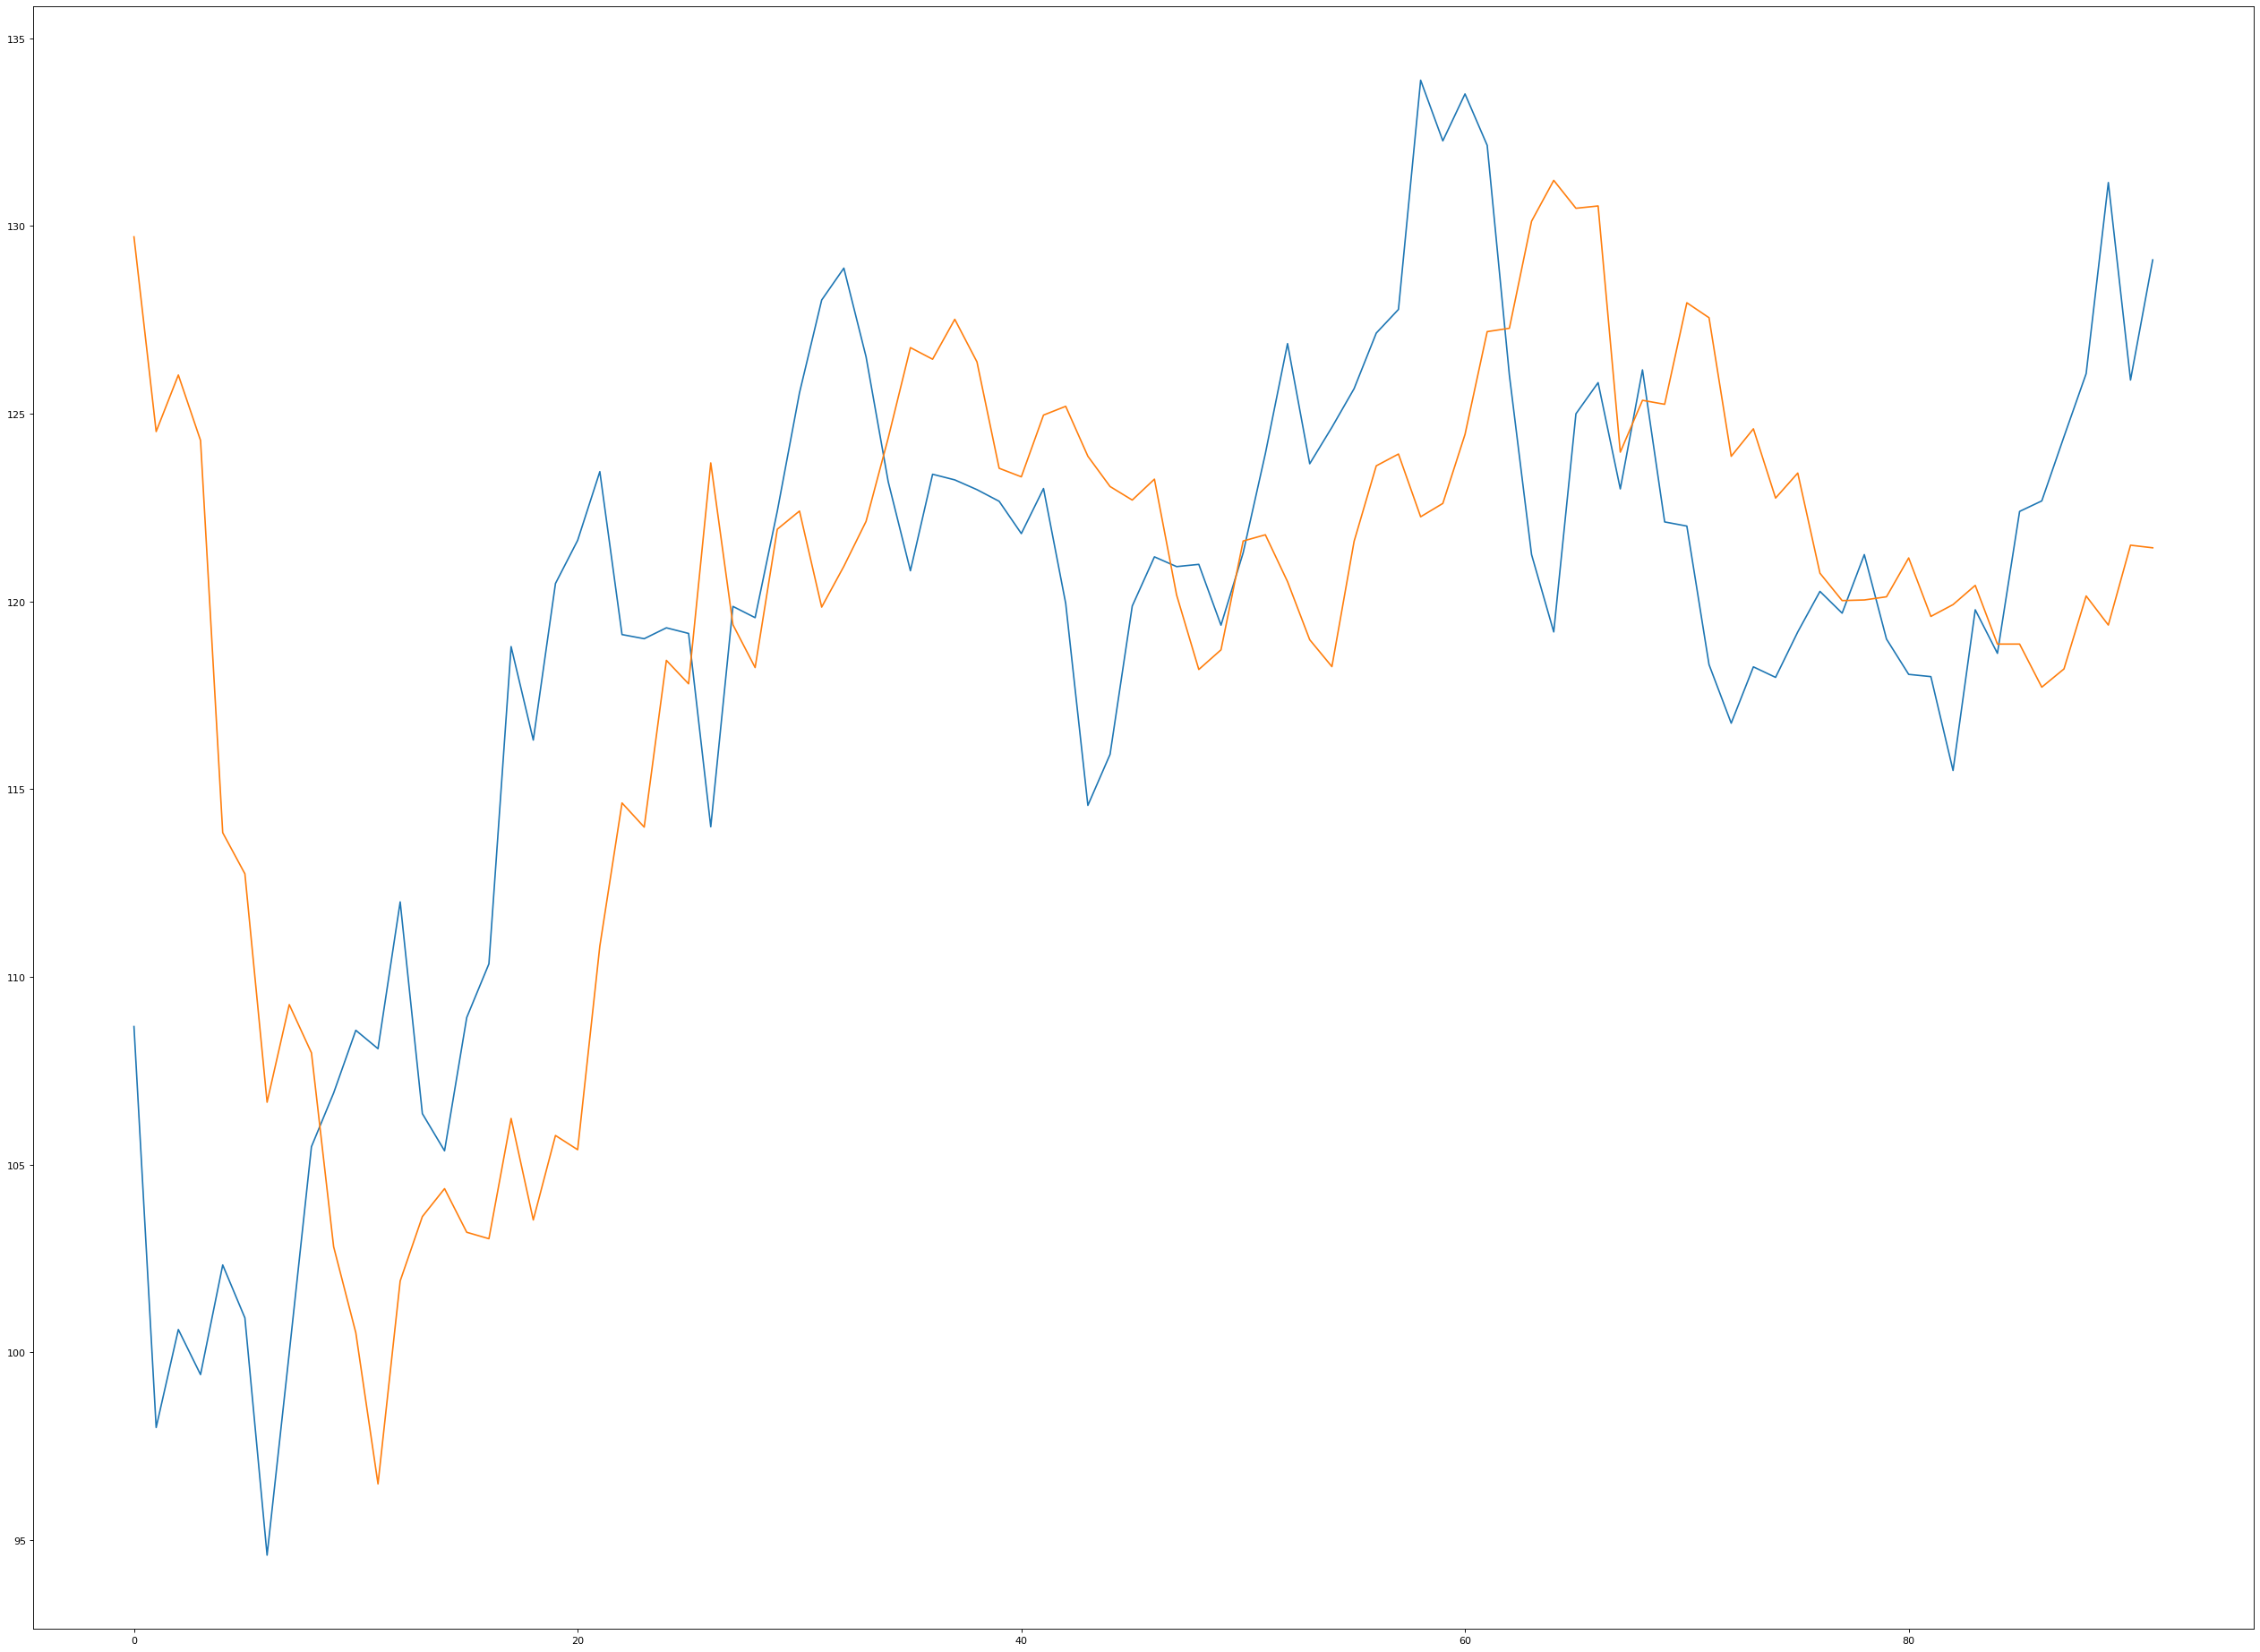

In [68]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), unscaled_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Actual week + prediction of next week (10 days)

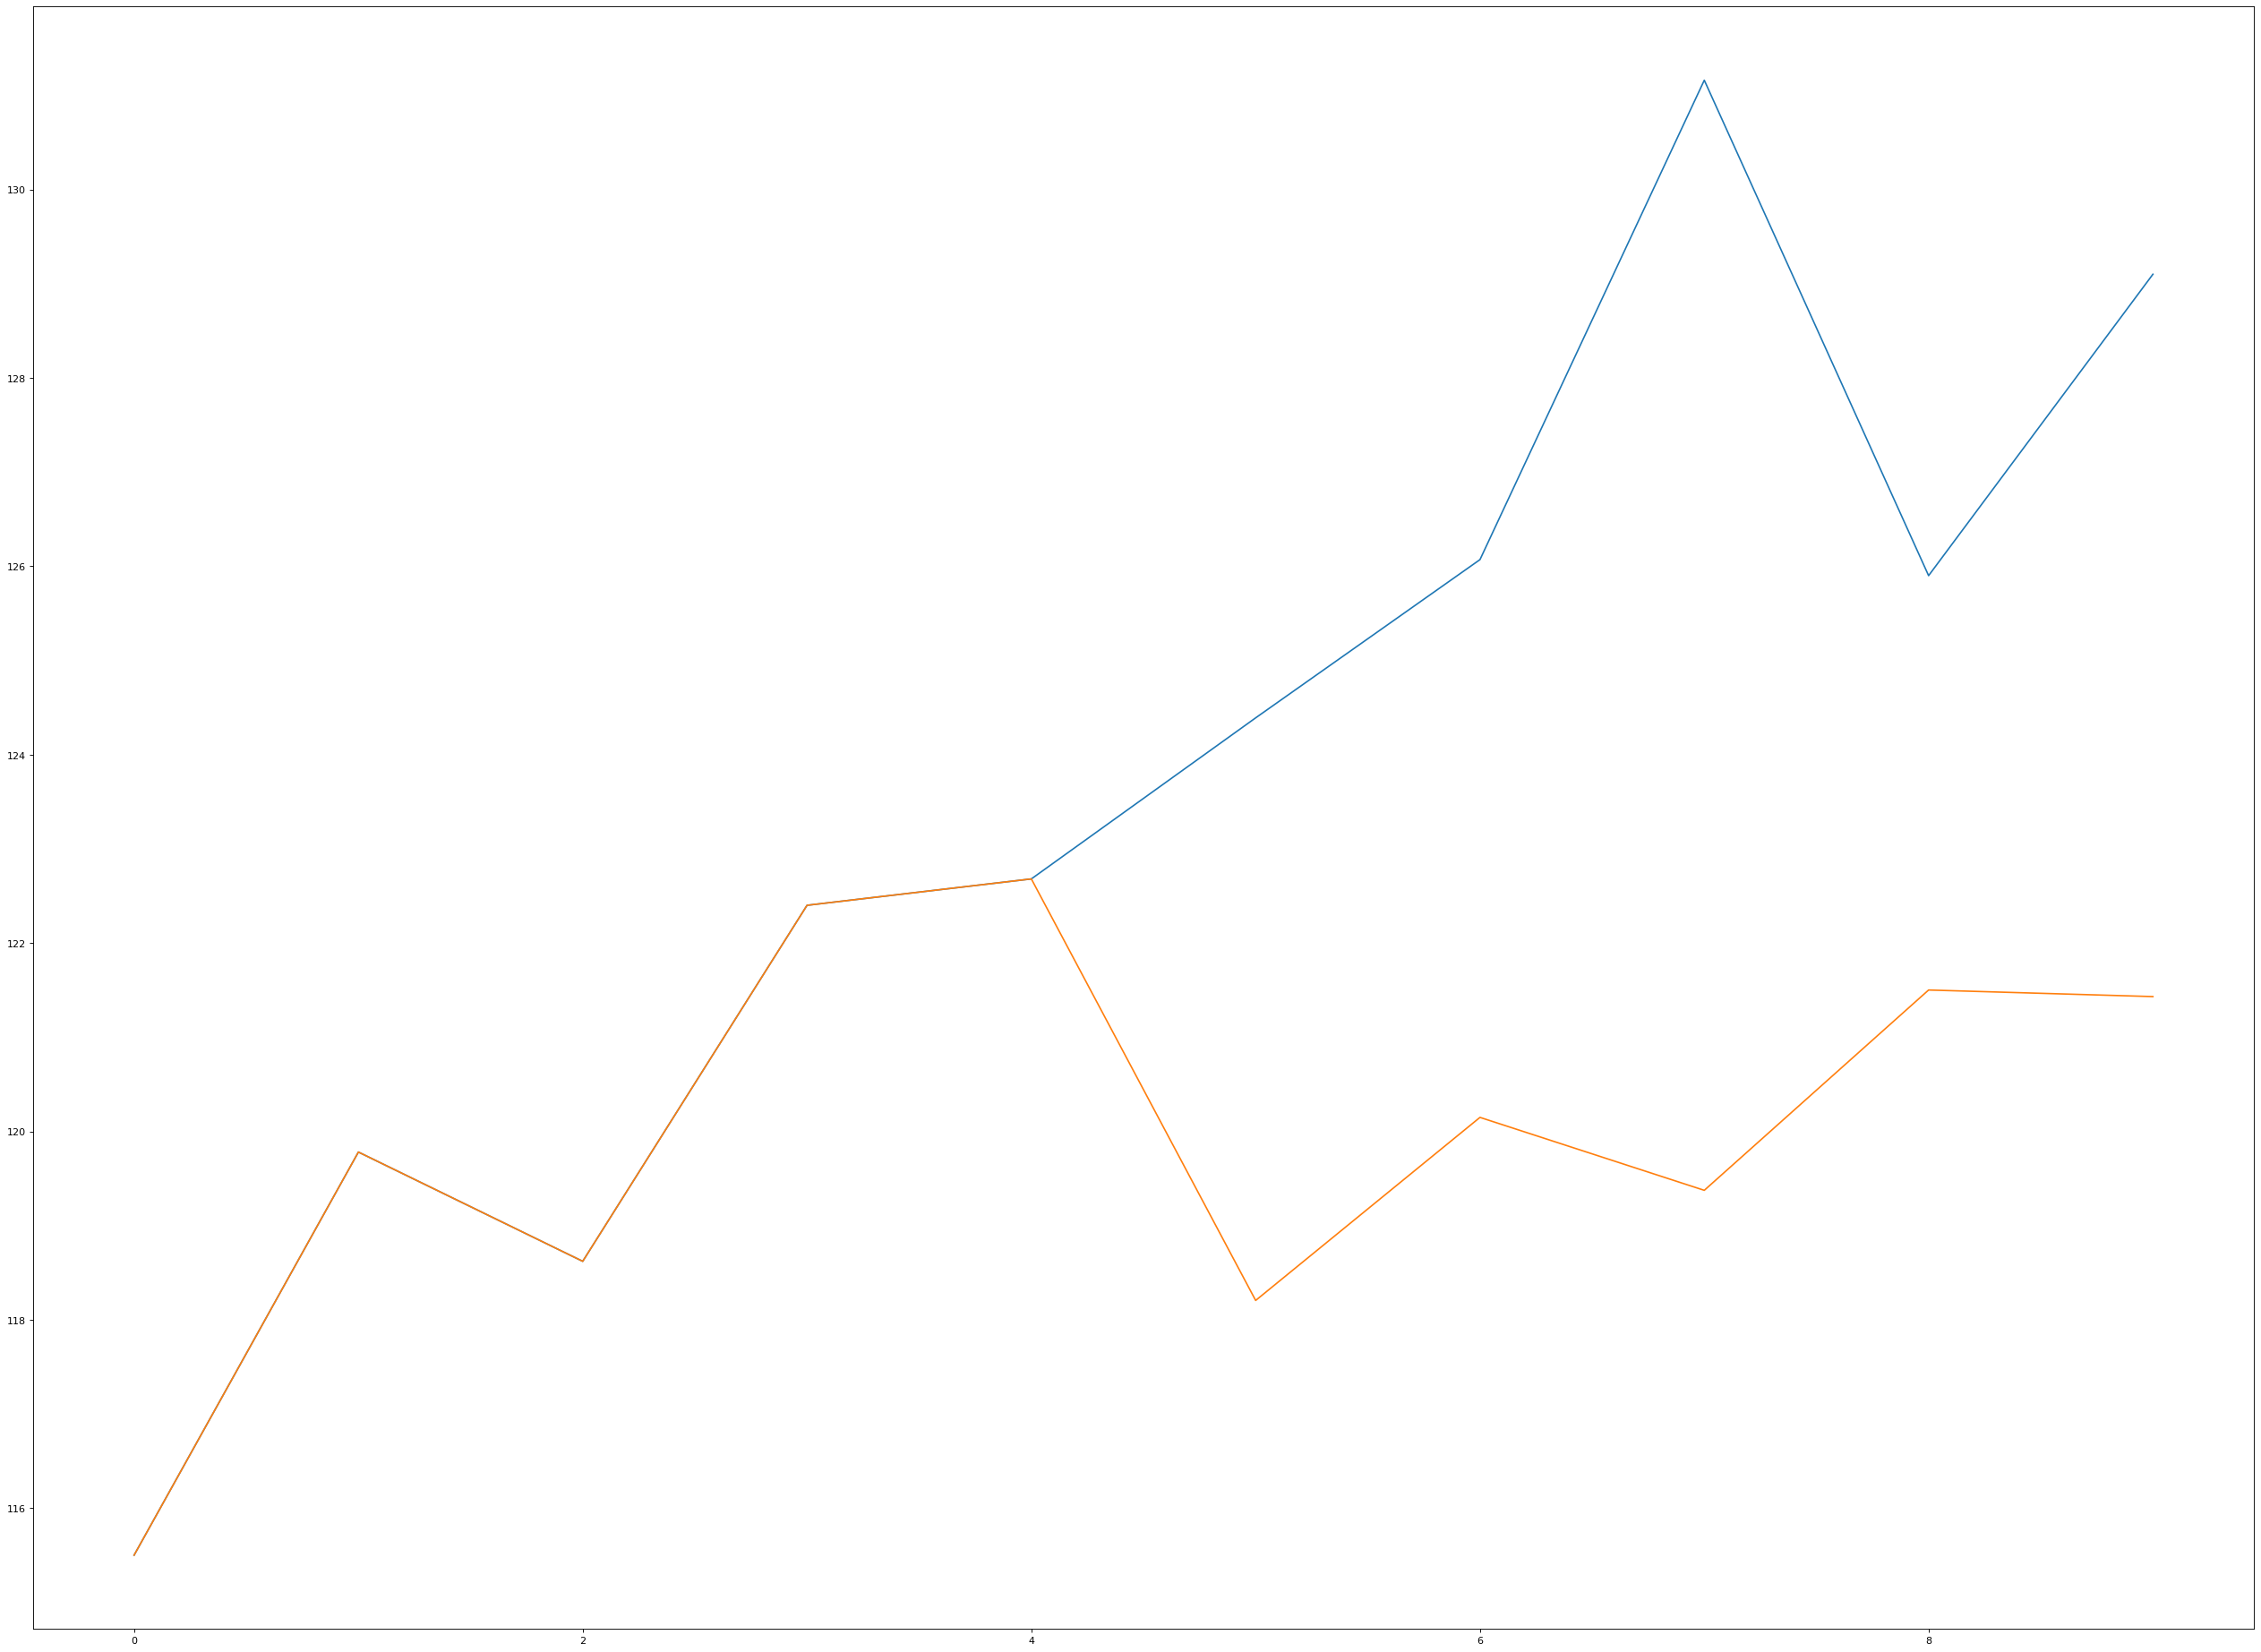

In [96]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(10), unscaled_y_test[-10:])
plt.plot(range(10), np.append(unscaled_y_test[-10:-5], predicted_y_test[-5:]))
plt.show()